In [17]:
from Manuel_BayesTRPL_Utilities import *

folder = r"C:\Users\kober-czerny\OneDrive - Nexus365\00_Oxford_PhD\00_Snaith Group\Projects_Collection\MKC06_Bayes\5_Data Collection\TRPL\2023_07_20_Bayes_Seongrok_FAPI"
trace_file = r"Seo_FAPI_trace_2024-05-11_151938.nc"

df, pile_up, sample_names, Fluences, Thickness, Surface, Absorption_coeff, Reflectance, intensity, max_arg, one_sun_carrier_density, spacing = Bayes_TRPL_Utils(folder, trace_file)

Files ready...


In [18]:
import os

import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import random
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [19]:
def golden_ratio(end_point):
        fib_list = [0,1,2]
    
        fib_stack = fib_list[-1]
        i = np.max(fib_stack)
        
        while i < end_point-1:
            fib_next = fib_list[-1]+fib_list[-2]  # fibonacci
            if fib_next <= end_point-1:
                fib_list.append(fib_next)
            
                i = np.max(fib_next)                
            else:
                break

        fib_list = np.array(fib_list)
        fib_list_sorted = np.sort(np.unique(fib_list))
        return fib_list_sorted

def squared_time(end_point):
        fib_list = [0,1,4]
    
        fib_stack = fib_list[-1]
        i = np.max(fib_stack)
        
        while i < end_point-1:
            fib_next = i**2           
            if fib_next <= end_point-1:
                fib_list.append(fib_next)
            
                i += 1
                
            else:
                break

        fib_list = np.array(fib_list)
        fib_list_sorted = np.sort(np.unique(fib_list))
        return fib_list_sorted

def log_time(end_point, no_points):

        fib_max = np.log(end_point-2)
        fib_list = np.logspace(0, fib_max, no_points, base=2.73)
        
        fib_list_sorted = np.unique(np.round(fib_list,0)-1)

        while fib_list_sorted[-1] > end_point:
            fib_list_sorted = fib_list_sorted[:-1]

        return np.array(fib_list_sorted).astype('int')

def logspacing(end_point, number_of_datapoints):

    len_a = 0
    nod = number_of_datapoints
    while len_a < number_of_datapoints:
        
        a = log_time(end_point, nod)
        len_a = len(a)
        nod += 1

    return a
    

def lin_time(end_point):
    return np.arange(0,end_point-2)



def spacing_choose(spacing, end_point):

    if spacing == 'linear':
        a = lin_time(end_point)
    
    elif spacing == 'squared':
        a = squared_time(end_point)

    elif 'log' in spacing:
        a = logspacing(end_point, int(spacing[3:]))

    else:
        print('spacing not implemented...')

    return a

In [20]:
trace = az.from_netcdf(f'{folder}/{trace_file}')
    
trace_file_split = trace_file.split('_trace_')
sample_name = str(trace_file_split[0] + ".csv")


a = spacing_choose(spacing, max_arg)


centimeters = 1/2.54
fontsize_base = 12
color1 = cm.Set2(np.arange(7))

color2 = cm.Dark2(np.arange(7))

time_plot = np.array(df['Time'])[a]

(180,)


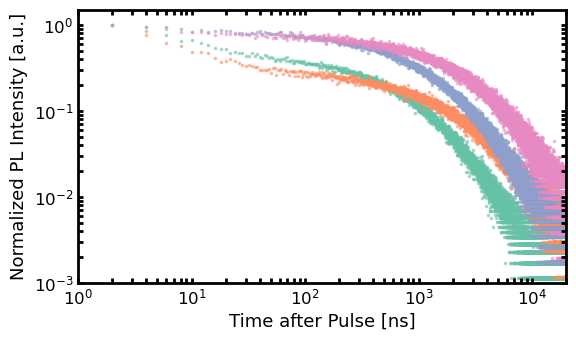

In [21]:

from matplotlib.animation import FuncAnimation 

fig_one = plt.figure(figsize=(16*centimeters, 9*centimeters))
plt.subplots_adjust(wspace=0.2, hspace=0)
gs_one = gridspec.GridSpec(1, 1)

ax_center = fig_one.add_subplot(gs_one[0, 0])
ax_center.set_xlabel('Time after Pulse [ns]', fontsize=fontsize_base+1)
ax_center.set_ylabel('Normalized PL Intensity [a.u.]', fontsize=fontsize_base+1)
ax_center.set_xscale('log')
ax_center.set_yscale('log')
ax_center.set_xlim(1,2e4)
ax_center.set_ylim(1e-3,1.5)


for plot_name in [ax_center]:
    for axis in ['top', 'bottom', 'left', 'right']:
        plot_name.spines[axis].set_linewidth(2)
    plot_name.tick_params(bottom=True,top=True,left=True,right=True,
                direction='in',width=2, length=3.5, which='both', labelsize=fontsize_base, zorder=2000)


N_calc_vals = trace.posterior.N_calc_collect.values#.ravel()[np.where(trace.sample_stats.diverging.values == 1)]

#lines = ax_center.plot([], [], lw = 2, color='grey')

lines = [] 
for n in range(len(Surface)):
    ## Plot Data
    ax_center.scatter(df['Time'], df[str(n)], marker='.',s=10 ,alpha=0.5, color=color1[n])
    lobj = ax_center.plot([],[],lw=2.5,color=color2[n])[0]
    lines.append(lobj)


def init(): 
    for line in lines:
        line.set_data([], [])
    return lines

def animate(s):
    
    N_step = np.nanmedian(N_calc_vals[:,s,:,:], axis=[0])

    for n, line in enumerate(lines):

        ## Plot Data
        line.set_data(time_plot, N_step[:,n])

    ax_center.annotate(str('Step: ' + str(s)) ,[0.7, 0.9] , xycoords='axes fraction', fontsize=fontsize_base+3, bbox=dict(boxstyle="round", fc="w", ec='w'))
    return lines

    

#frame_list = np.arange(20)
#frame_list = np.append(frame_list, np.linspace(21,201,10))
#frame_list = np.append(frame_list, np.linspace(202,2202,50))

raw_list = np.logspace(0, np.log10(np.shape(N_calc_vals)[1]-1), 6*30)
frame_list = raw_list.astype('int')

print(np.shape(list(frame_list)))

In [16]:
anim = FuncAnimation(fig_one, animate, init_func = init,
                     frames = list(frame_list), blit = True)
  

videoname = str('Bayes-MCMC_Video_30fps')
anim.save(f'{folder}/{videoname}.mp4', 
          writer = 'ffmpeg', fps = 60, dpi=300)

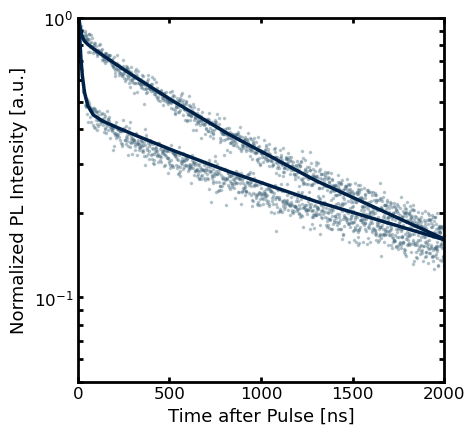

In [121]:
fig_one = plt.figure(figsize=(12*centimeters, 12*centimeters))
plt.subplots_adjust(wspace=0.2, hspace=0)
gs_one = gridspec.GridSpec(1, 1)

ax_center = fig_one.add_subplot(gs_one[0, 0])
ax_center.set_xlabel('Time after Pulse [ns]', fontsize=fontsize_base+1)
ax_center.set_ylabel('Normalized PL Intensity [a.u.]', fontsize=fontsize_base+1)
#ax_center.set_xscale('log')
ax_center.set_yscale('log')
ax_center.set_xlim(0,2000)
ax_center.set_ylim(5e-2,1)


N_calc_median = np.nanmedian(N_calc_vals, axis=[0,1])

ax_center.scatter(df['Time'], df['1'], marker='.',s=10 ,alpha=0.3, color="#44687d")
ax_center.scatter(df['Time'], df['2'], marker='.',s=10 ,alpha=0.3, color="#44687d")

ax_center.plot(time_plot,N_calc_median[:,1],lw=2.5,color="#002147")
ax_center.plot(time_plot,N_calc_median[:,2],lw=2.5,color="#002147")


for plot_name in [ax_center]:
    for axis in ['top', 'bottom', 'left', 'right']:
        plot_name.spines[axis].set_linewidth(2)
    plot_name.tick_params(bottom=True,top=True,left=True,right=True,
                direction='in',width=2, length=3.5, which='both', labelsize=fontsize_base, zorder=2000)


In [19]:
n_e = 1e18 * np.exp(-0.15/(8.6e-5*300))

Nc_new = 0.8e18

delta_E = -np.log(n_e/Nc_new) * 8.6e-5*300

print(delta_E)

0.1442428963760934


In [111]:
mu_0 = 27
mu_D = mu_0 * 1/(1 + 2e16/1e18 * np.exp(0.14/(8.6e-5*300)))

print(mu_D)

4.868030989647566


In [112]:

m_e = 9.10938e-31 * 0.117
h = 6.626e-34
k = 1.380e-23

N_c = 2* (2*np.pi*m_e*k*300/(h**2))**(3/2) *1e-6

print(N_c)

1.0035939546565778e+18


In [114]:
N_t = N_c * (mu_0/(1.5) - 1) * np.exp(-0.14/(8.6e-5*300))

print("{:.2e}".format(N_t))

7.51e+16


In [84]:
eps_0 = 8.854e-12 * 25

d = 600e-9
N_def = 4*np.pi**2*eps_0*k*300/(d**2*1.602e-19**2)*1e-6

print("{:.2e}".format(N_def))

3.92e+15


In [64]:
print((1.380649e-23*292/1.6021766e-19))

0.025162613659443035
